In [1]:
%matplotlib inline

In [5]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
from numpy i
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio

In [3]:
### Starry Configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [9]:
### Read in Data

file = open('GaiaDR2_4616932063282660608.csv', 'rb')
data = np.loadtxt(file,delimiter = ",",skiprows=1)

In [19]:
### Choose Sector

sector = 27

In [73]:
### Rotation Period

period_days = 5.19
period_hours = 5.19 * 24

In [25]:
### Sector time and flux lists

sector_flux = []
sector_time = []

In [55]:
### Append flux and time values to array

for i in range(len(data)-1):
    if data[i][2] == 27:
        sector_flux.append(data[i][1])
        sector_time.append(data[i][0])

In [56]:
### Normalize flux array to 1

sector_flux_normalized = [x+1 for x in sector_flux]

In [57]:
### Calculate Error

flux_error = np.zeros_like(sector_flux) + 0.5

In [58]:
### Choose ydeg for maps

ydeg = 1

In [59]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=ydeg, reflected=False)
map.obl = 0
map.inc = 90

In [60]:
## set the data vector (the flux and the covariance matrix)
map.set_data(sector_flux_normalized, C=flux_error**2)

In [61]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [74]:
### More map variables

nrot=max(sector_time)/period_hours # Calculate the number of rotations
npts = len(sector_time) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(sector_time, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [63]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 427 ms, sys: 214 ms, total: 641 ms
Wall time: 409 ms


In [64]:
map.show(colorbar=True, projection="moll",file="sector"+str(sector)+"_ydeg"+str(ydeg)+"_map.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


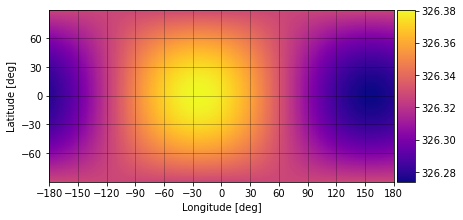

In [65]:
map.show(colorbar=True, projection="rect")

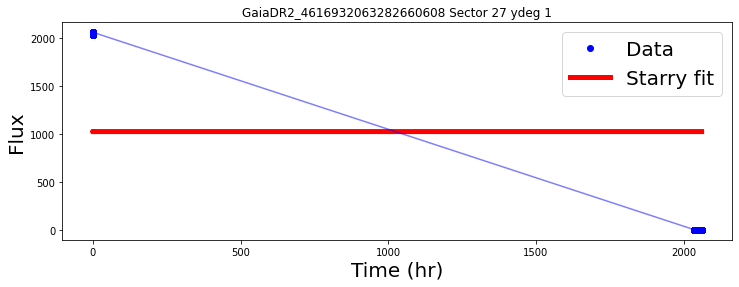

In [69]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("GaiaDR2_4616932063282660608 Sector " + str(sector)+" ydeg "+str(ydeg))
plt.plot(sector_time, sector_flux,label="Data",linestyle="none",marker="o",color="blue")
#plt.ylim(0.98,1.02)
plt.plot(sector_time, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(sector_time, sector_flux, flux_error,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Flux", fontsize=20)
plt.savefig("sector"+str(sector)+"_ydeg"+str(ydeg)+".jpg")

In [72]:
sector_flux

[2036.2833805394434,
 2036.2903249531155,
 2036.297269366787,
 2036.304213780458,
 2036.311158194012,
 2036.318102607567,
 2036.325047021005,
 2036.3319914344434,
 2036.3389358478826,
 2036.3458802613209,
 2036.3528246746423,
 2036.359769087964,
 2036.3667135012865,
 2036.3736579144925,
 2036.380602327697,
 2036.3875467409025,
 2036.394491153992,
 2036.4014355670815,
 2036.408379980171,
 2036.415324393143,
 2036.4222688061154,
 2036.4292132190885,
 2036.4361576319443,
 2036.4431020449174,
 2036.4500464576581,
 2036.4569908705134,
 2036.4639352832535,
 2036.470879695993,
 2036.4778241087336,
 2036.484768521358,
 2036.4917129339801,
 2036.4986573466035,
 2036.505601759111,
 2036.512546171618,
 2036.5194905841254,
 2036.5264349965155,
 2036.533379408906,
 2036.540323821297,
 2036.547268233571,
 2036.5542126459625,
 2036.561157058236,
 2036.568101470393,
 2036.5750458825514,
 2036.5819902947096,
 2036.588934706867,
 2036.5958791189084,
 2036.60282353095,
 2036.6097679429915,
 2036.61671235